In [1]:
%%HTML
<style>
    /* style for presentation only */
    .reveal .rendered_html table { font-size: 24px }
</style> 

# Cartography with Python
Setup

In [1]:
import pip
pip.main("install -q osmnx matplotlib pandas geopandas shapely descartes".split())
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
from descartes import PolygonPatch
import pandas as pd
import geopandas as gpd
cmap=plt.cm.get_cmap('jet')
from matplotlib import colors as colors
from matplotlib import colorbar 
from IPython.display import display
points = {
    'belfast':(54.5973, -5.9301),
    'farset': (54.592789, -5.940715),
    'dublin':(53.3498, -6.2603)
}
dist = 1000 # metres 
figsize = 12

%matplotlib inline

# Basic Mapping with OSMNX

In [2]:
# get the network within 1km north, south, east, and west of the point, then project to UTM
G = ox.graph_from_point(points['farset'], distance=dist, distance_type='bbox', network_type='all', truncate_by_edge=False)
G = ox.project_graph(G)
# create the plot's bounding box in meters to limit the plot to the square mile bounding box requested
# this is only necessary when truncate_by_edge=True to prevent display of nodes/edges that extend beyond bounding box
bbox_proj = ox.bbox_from_point(points['farset'], dist*0.8, project_utm=True)

# plot the graph and save it to disk
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=32, node_color='b',
                        edge_linewidth=2, file_format='png', edge_color='w', bgcolor='#47494c', 
                        show=False)

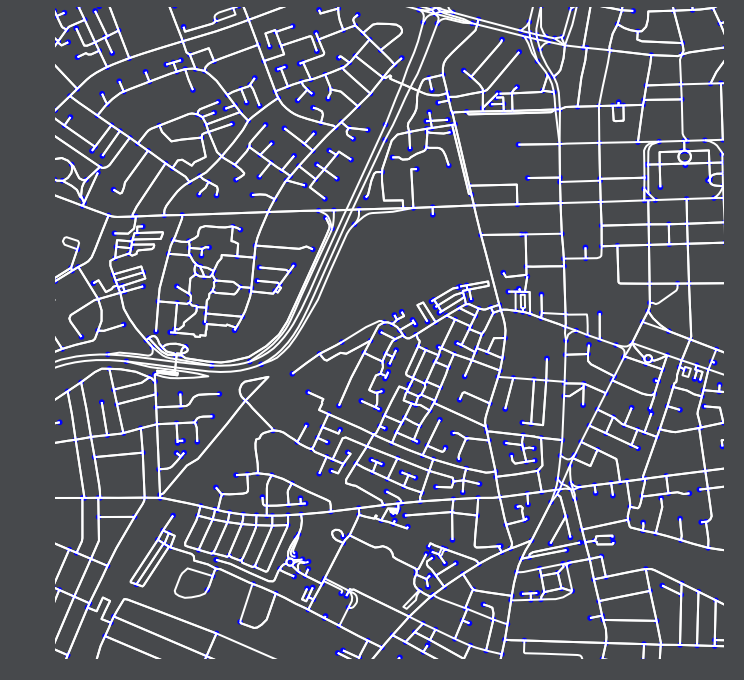

In [8]:
fig

## So what else is there?
OpenStreetMap has a wealth of information available on the nature of roads and paths

In [9]:
for u, v, key, data in G.edges(keys=True, data=True):
    print(u,v,key,data)
    break

351599 351600 0 {'osmid': 5209408, 'ref': 'B503', 'name': 'Sandy Row', 'highway': 'secondary', 'maxspeed': '30 mph', 'oneway': False, 'length': 68.01975307083063, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f0517635400>}


In [10]:
edges = []
for u, v, key, data in G.edges(keys=True, data=True):
    edge = dict(
        u=u,
        v=v,
        key=key
    )
    edge.update(data)
    edges.append(edge)
df = pd.DataFrame.from_records(edges)
df.head()

access area bridge                                           geometry  \
0    NaN  NaN    NaN  LINESTRING (310253.2789656966 6053281.71978036...   
1    NaN  NaN    NaN  LINESTRING (310253.2789656966 6053281.71978036...   
2    NaN  NaN    NaN  LINESTRING (310253.2789656966 6053281.71978036...   
3    NaN  NaN    NaN                                                NaN   
4    NaN  NaN    NaN  LINESTRING (310273.103823845 6053346.87252892,...   

        highway  key lanes     length maxspeed       name  oneway     osmid  \
0     secondary    0   NaN  68.019753   30 mph  Sandy Row   False   5209408   
1     secondary    0   NaN  58.732023   30 mph  Sandy Row   False   5209408   
2  unclassified    0   NaN  89.353042      NaN        NaN   False  38485621   
3     secondary    0   NaN  16.131203   30 mph  Sandy Row   False   5209408   
4     secondary    0   NaN  68.019753   30 mph  Sandy Row   False   5209408   

    ref service tunnel       u           v width  
0  B503     NaN    NaN  351599      351600   NaN  
1  B503     NaN    NaN  351599  1121792828   NaN  
2   NaN     NaN    NaN  351599   455032602   NaN  
3  B503     NaN    NaN  351600   231772694   NaN  
4  B503     NaN    NaN  351600      351599   NaN

In [11]:
df.dtypes

access       object
area         object
bridge       object
geometry     object
highway      object
key           int64
lanes        object
length      float64
maxspeed     object
name         object
oneway         bool
osmid        object
ref          object
service      object
tunnel       object
u             int64
v             int64
width        object
dtype: object

In [12]:
objects = (df.dtypes==object)
objects

access       True
area         True
bridge       True
geometry     True
highway      True
key         False
lanes        True
length      False
maxspeed     True
name         True
oneway      False
osmid        True
ref          True
service      True
tunnel       True
u           False
v           False
width        True
dtype: bool

In [13]:
uniques = {}
for c in df[objects[objects].index]:
    try:
        uniques[c] = df[c].unique()
    except TypeError:
        print("Can't unique on {}".format(c))
uniques

Can't unique on geometry
Can't unique on highway
Can't unique on name
Can't unique on osmid
Can't unique on ref


{'access': array([nan, 'yes', 'no', 'destination', 'permissive'], dtype=object),
 'area': array([nan, 'no'], dtype=object),
 'bridge': array([nan, 'yes'], dtype=object),
 'lanes': array([nan, '2', '3', '4', '1'], dtype=object),
 'maxspeed': array(['30 mph', nan, '20 mph', '50 mph', '30'], dtype=object),
 'service': array([nan, 'parking_aisle', 'driveway', 'alley', 'emergency_access'], dtype=object),
 'tunnel': array([nan, 'yes', 'building_passage', 'covered'], dtype=object),
 'width': array([nan, '2', 'narrow'], dtype=object)}

In [14]:
df['width'] = df['width'].apply(lambda l: max(map(float,l)) if isinstance(l,list) else float(l))
df['lanes'] = df['lanes'].apply(lambda l: max(map(float,l)) if isinstance(l,list) else float(l))
#df['bridge'] = df['bridge'] == 'yes'
#df['area'] = df['area'] != 'no'
df['maxspeed'] = df['maxspeed'].apply(
    lambda s: float(
        ''.join([
            c for c in s if c.isdigit()
        ])) 
    if isinstance(s,str) else None)

ValueError: could not convert string to float: 'narrow'

# Plotting with Values
## Speed Limits

In [74]:
df['maxspeed'].unique()

array([ nan,  30.,  20.,  50.,  40.])

In [75]:
def maxspeed_colormap(f):
    if np.isnan(f):
        return 'gray'
    else:
        return {20:'c',30:'g',40:'y',50:'r', 16:'plum', 10:'purple'}[f]
maxspeed_colours = df['maxspeed'].apply(maxspeed_colormap).values

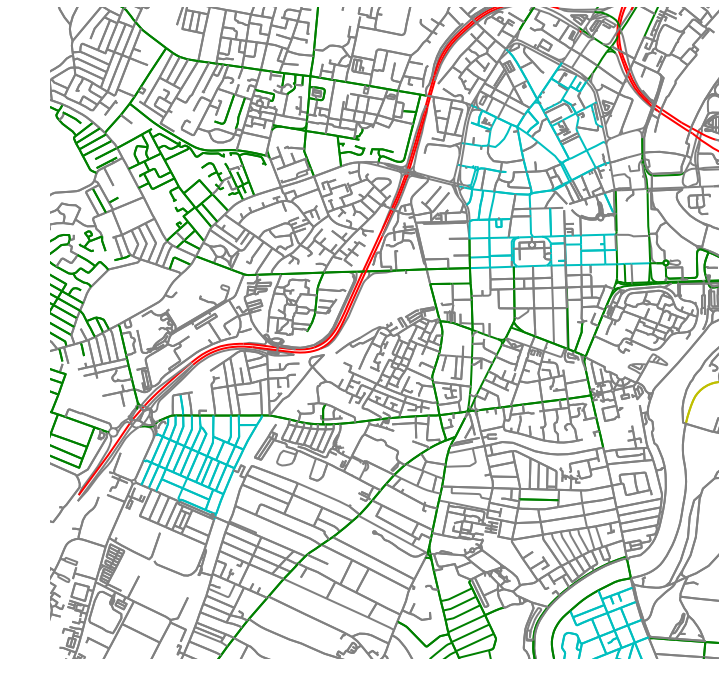

In [76]:
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, node_color='b', 
                        edge_linewidth=2, file_format='png', edge_color=maxspeed_colours, bgcolor='w',
                        show=True)

## Road Type

In [77]:
df[df['highway'].apply(lambda o: isinstance(o,list))].head()

access area bridge                                           geometry  \
100    NaN  NaN    NaN  LINESTRING (309054.9012551153 6051879.39949678...   
146    NaN  NaN    NaN  LINESTRING (310508.6658935357 6052585.47432295...   
372    NaN  NaN    NaN  LINESTRING (310746.6189685508 6052240.50443621...   
398    NaN  NaN    NaN  LINESTRING (309998.7612512931 6053032.48635245...   
467    NaN  NaN    NaN  LINESTRING (311365.2561070879 6053725.44614958...   

                     highway  key  lanes      length  maxspeed  \
100   [residential, footway]    0    NaN   63.623945       NaN   
146  [residential, tertiary]    0    NaN  106.060851       NaN   
372   [residential, footway]    0    NaN   89.569145       NaN   
398   [residential, footway]    0    NaN  161.786445       NaN   
467         [footway, steps]    0    NaN   22.778507       NaN   

                               name  oneway  \
100                 Adelaide Avenue   False   
146  [College Park, Botanic Avenue]   False   
372                   Botanic Court   False   
398   [Felt Street, Utility Street]   False   
467                             NaN   False   

                                 osmid  ref service tunnel         u  \
100                [91885161, 4892327]  NaN     NaN    NaN  31827743   
146               [5209490, 442488830]  NaN     NaN    NaN  36453448   
372               [18606081, 39222963]  NaN     NaN    NaN  82318409   
398    [96822456, 103412513, 41456291]  NaN     NaN    NaN  82327829   
467  [193480257, 193326219, 193326215]  NaN     NaN    NaN  83727631   

              v  width  
100  4725590933    NaN  
146   191935661    NaN  
372   191928850    NaN  
398  2060719493    NaN  
467  2038374766    NaN

In [78]:
from collections import Counter
highway_counter = Counter()
highway_counter.update(df[df['highway'].apply(lambda o: not isinstance(o,list))]['highway'].values)
highway_counter.update([i for l in df[df['highway'].apply(lambda o:isinstance(o,list))]['highway'].values for i in l])
highway_counter

Counter({'corridor': 32,
         'cycleway': 37,
         'footway': 1258,
         'living_street': 164,
         'motorway': 7,
         'motorway_link': 19,
         'path': 188,
         'pedestrian': 216,
         'primary': 162,
         'primary_link': 3,
         'residential': 4044,
         'secondary': 493,
         'secondary_link': 13,
         'service': 2415,
         'steps': 84,
         'tertiary': 372,
         'tertiary_link': 14,
         'trunk': 579,
         'trunk_link': 66,
         'unclassified': 1029})

In [79]:
cmap=plt.cm.get_cmap('Paired', len(highway_counter))
highway_colourmap = {}
for (k,v),c in zip(highway_counter.most_common(),cmap.colors):
    highway_colourmap[k]=c
highway_colourmap

{'corridor': array([ 0.79215686,  0.69803922,  0.83921569,  1.        ]),
 'cycleway': array([ 0.79215686,  0.69803922,  0.83921569,  1.        ]),
 'footway': array([ 0.12156863,  0.47058824,  0.70588235,  1.        ]),
 'living_street': array([ 0.89019608,  0.10196078,  0.10980392,  1.        ]),
 'motorway': array([ 0.69411765,  0.34901961,  0.15686275,  1.        ]),
 'motorway_link': array([ 0.41568627,  0.23921569,  0.60392157,  1.        ]),
 'path': array([ 0.89019608,  0.10196078,  0.10980392,  1.        ]),
 'pedestrian': array([ 0.98431373,  0.60392157,  0.6       ,  1.        ]),
 'primary': array([ 0.99215686,  0.74901961,  0.43529412,  1.        ]),
 'primary_link': array([ 0.69411765,  0.34901961,  0.15686275,  1.        ]),
 'residential': array([ 0.65098039,  0.80784314,  0.89019608,  1.        ]),
 'secondary': array([ 0.2       ,  0.62745098,  0.17254902,  1.        ]),
 'secondary_link': array([ 1. ,  1. ,  0.6,  1. ]),
 'service': array([ 0.65098039,  0.80784314,  

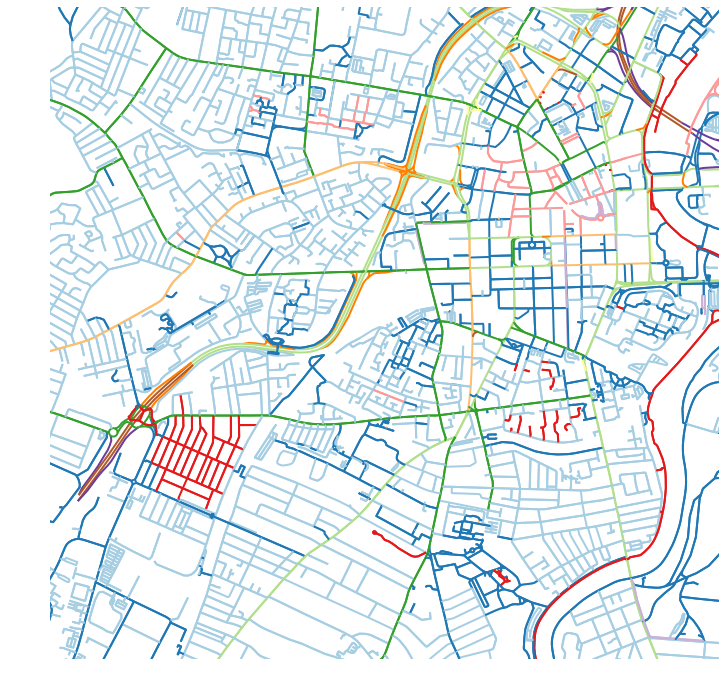

In [80]:
highway_colours = df['highway'].apply(lambda h: highway_colourmap[h[0]] if isinstance(h,list) else highway_colourmap[h])
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, node_color='b', 
                        edge_linewidth=2, file_format='png', edge_color=highway_colours, bgcolor='w', 
                        show=True)

## Varying road widths

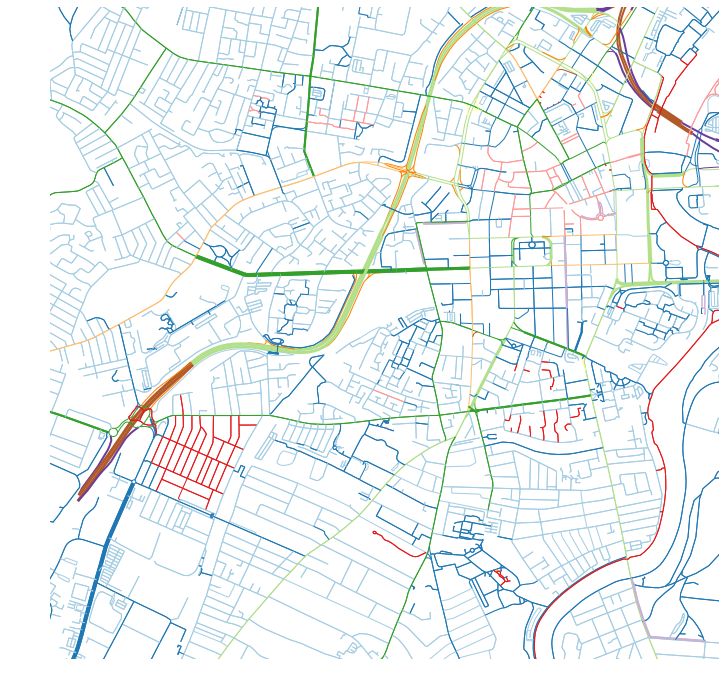

In [81]:
df['display_width'] = df[['width','lanes']].sum(axis=1).fillna(1.0)
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, node_color='b', 
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, bgcolor='w', 
                        show=True)

# Graph Theory; what's the most connected junction around Farset?

In [82]:
nodes = []
for key,data in G.nodes(data=True):
    node = dict(key=key)
    node.update(data)
    nodes.append(node)
ndf = pd.DataFrame.from_records(nodes)
ndf.head()

highway     key        lat       lon   osmid  ref              x  \
0     NaN  351532  54.588230 -5.958477  351532  NaN  308845.304399   
1     NaN  351599  54.591331 -5.936903  351599  NaN  310253.278966   
2     NaN  351600  54.591923 -5.936638  351600  NaN  310273.103824   
3     NaN  351601  54.588157 -5.935911  351601  NaN  310302.616444   
4     NaN  351650  54.592115 -5.925790  351650  NaN  310974.707640   

              y  
0  6.052995e+06  
1  6.053282e+06  
2  6.053347e+06  
3  6.052926e+06  
4  6.053339e+06

### Extra Statistics provided by osmnx

In [83]:
centrality = ox.nx.betweenness_centrality(G,weight='length')
ndf['centrality'] = ndf['key'].apply(lambda k: centrality[k])
ndf['centrality'].describe()

count    4429.000000
mean        0.007575
std         0.016890
min         0.000000
25%         0.000172
50%         0.001617
75%         0.006496
max         0.173801
Name: centrality, dtype: float64

In [84]:
cmap=plt.cm.get_cmap('jet')
from matplotlib import colors as colors
norm = colors.Normalize(vmin=ndf['centrality'].min(), vmax=ndf['centrality'].max())
centrality_size = ndf['centrality'].apply(norm)*128
centrality_colors = ndf['centrality'].apply(norm).apply(cmap).values

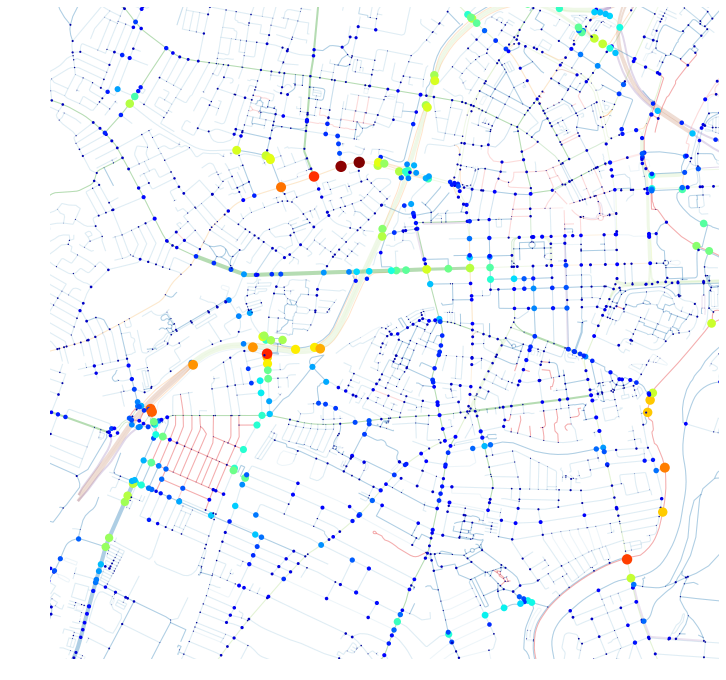

In [85]:
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=centrality_size, node_color=centrality_colors, node_zorder=2,
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.2, bgcolor='w', 
                        show=True)

In [86]:
basic_stats = ox.basic_stats(G, area=(2*dist)**2)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)

In [87]:
stats={**basic_stats,**extended_stats}
', '.join(stats.keys())

'n, m, k_avg, intersection_count, streets_per_node_avg, streets_per_node_counts, streets_per_node_proportion, edge_length_total, edge_length_avg, street_length_total, street_length_avg, street_segments_count, node_density_km, intersection_density_km, edge_density_km, street_density_km, circuity_avg, self_loop_proportion, clean_intersection_count, clean_intersection_density_km, avg_neighbor_degree, avg_neighbor_degree_avg, avg_weighted_neighbor_degree, avg_weighted_neighbor_degree_avg, degree_centrality, degree_centrality_avg, clustering_coefficient, clustering_coefficient_avg, clustering_coefficient_weighted, clustering_coefficient_weighted_avg, pagerank, pagerank_max_node, pagerank_max, pagerank_min_node, pagerank_min, eccentricity, diameter, radius, center, periphery, closeness_centrality, closeness_centrality_avg, betweenness_centrality, betweenness_centrality_avg'

In [88]:
pd.Series({k:v for k,v in stats.items() if not isinstance(v,dict)})

avg_neighbor_degree_avg                    2.73866
avg_weighted_neighbor_degree_avg         0.0790286
betweenness_centrality_avg              0.00757512
center                                 [925968742]
circuity_avg                           1.30364e-05
clean_intersection_count                      None
clean_intersection_density_km                 None
closeness_centrality_avg               0.000409184
clustering_coefficient_avg               0.0424776
clustering_coefficient_weighted_avg     0.00241697
degree_centrality_avg                   0.00110904
diameter                                   6645.69
edge_density_km                            40475.5
edge_length_avg                            59.5502
edge_length_total                           647609
intersection_count                            3504
intersection_density_km                        219
k_avg                                      4.91082
m                                            10875
n                              

In [89]:
pd.Series({k:len(v) for k,v in stats.items() if isinstance(v,dict)})

avg_neighbor_degree                4429
avg_weighted_neighbor_degree       4429
betweenness_centrality             4429
closeness_centrality               4429
clustering_coefficient             4429
clustering_coefficient_weighted    4429
degree_centrality                  4429
eccentricity                       4389
pagerank                           4429
streets_per_node_counts               7
streets_per_node_proportion           7
dtype: int64

In [90]:
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(1604301260, 0.17380121787703898)

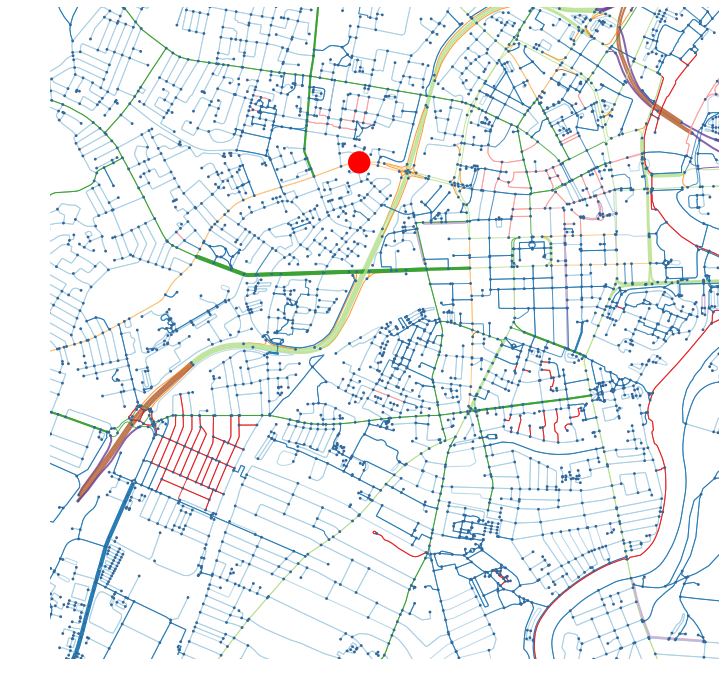

(<matplotlib.figure.Figure at 0x7f3c0281ad68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c0281a6d8>)

In [91]:
nc = ['r' if node==max_node else '#336699' for node in G.nodes()]
ns = [500 if node==max_node else 8 for node in G.nodes()]
ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, show=True, bbox=bbox_proj, fig_height=figsize, margin=0, 
            edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.8, bgcolor='w',)

# How Central is Farset? What are the travel times?

In [92]:
center_node = 2698751105

farset_stats = pd.Series({k:v[center_node] for k,v in stats.items() if isinstance(v,dict) and center_node in v})
farset_stats

avg_neighbor_degree                   2.333333
avg_weighted_neighbor_degree          0.068526
betweenness_centrality                0.007604
closeness_centrality                  0.000508
clustering_coefficient                0.000000
clustering_coefficient_weighted       0.000000
degree_centrality                     0.001355
eccentricity                       3746.462214
pagerank                              0.000328
dtype: float64

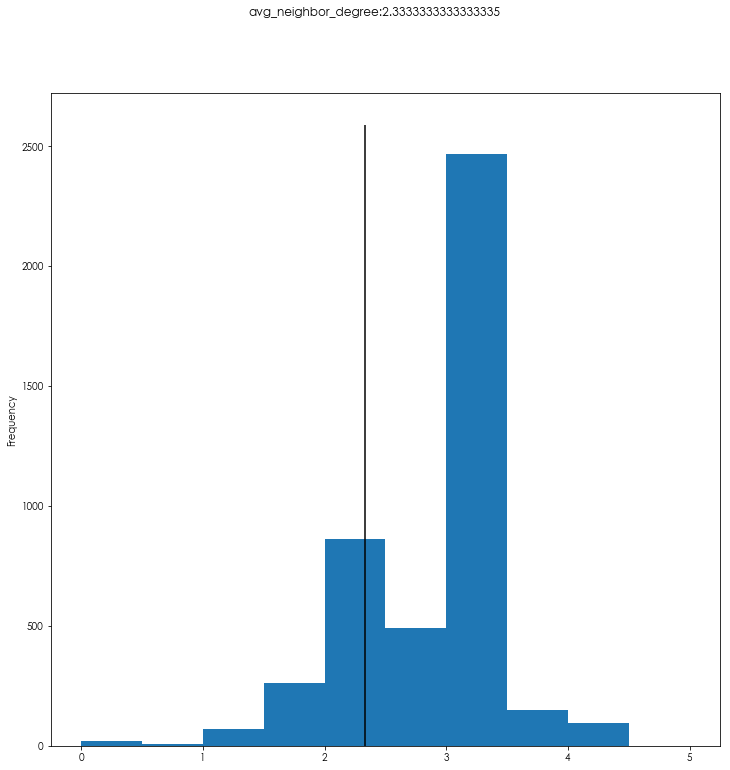

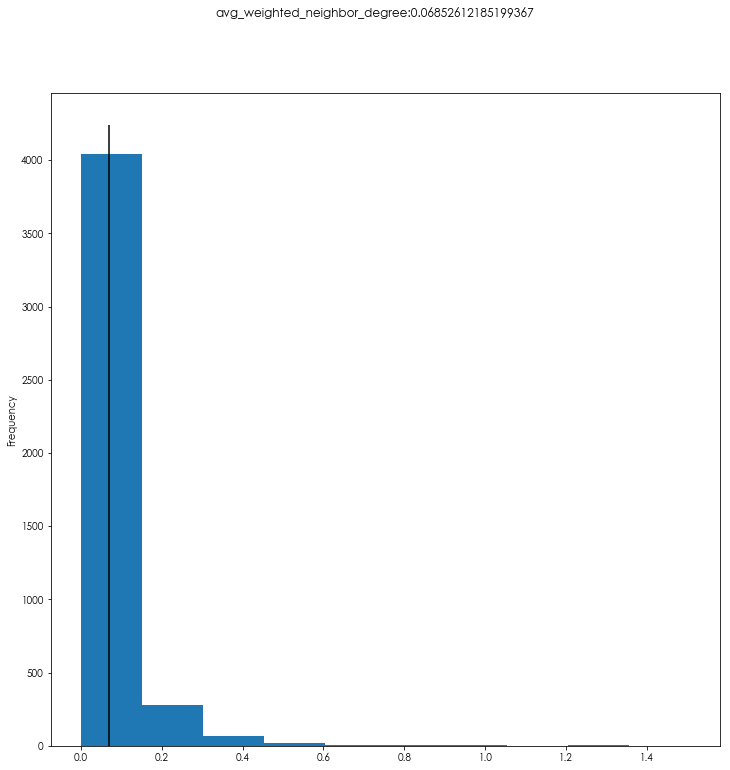

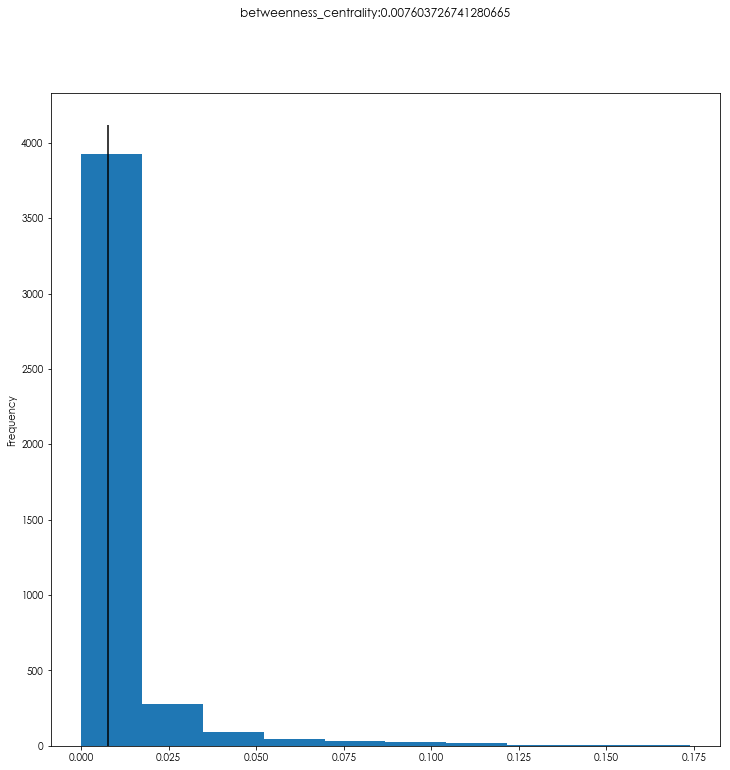

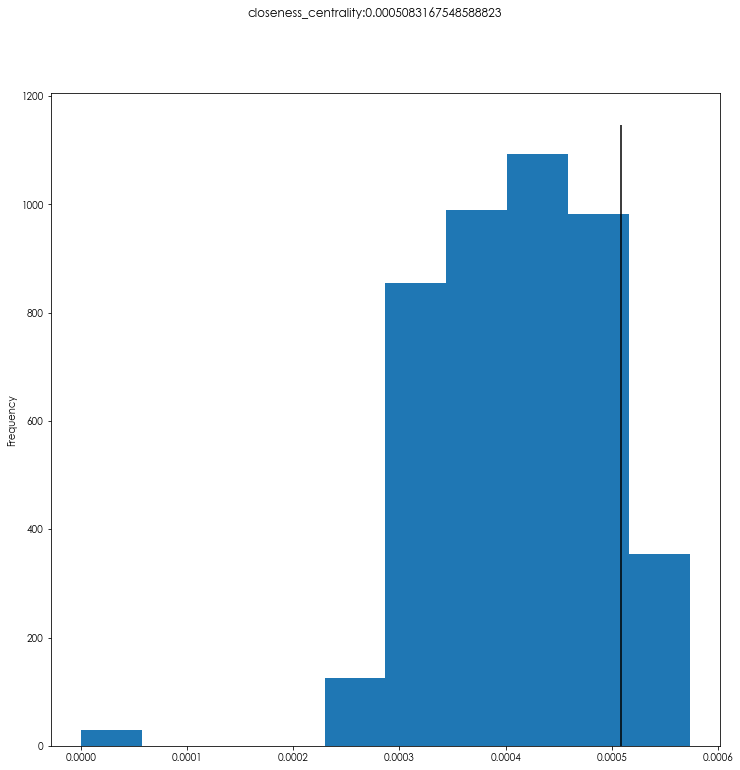

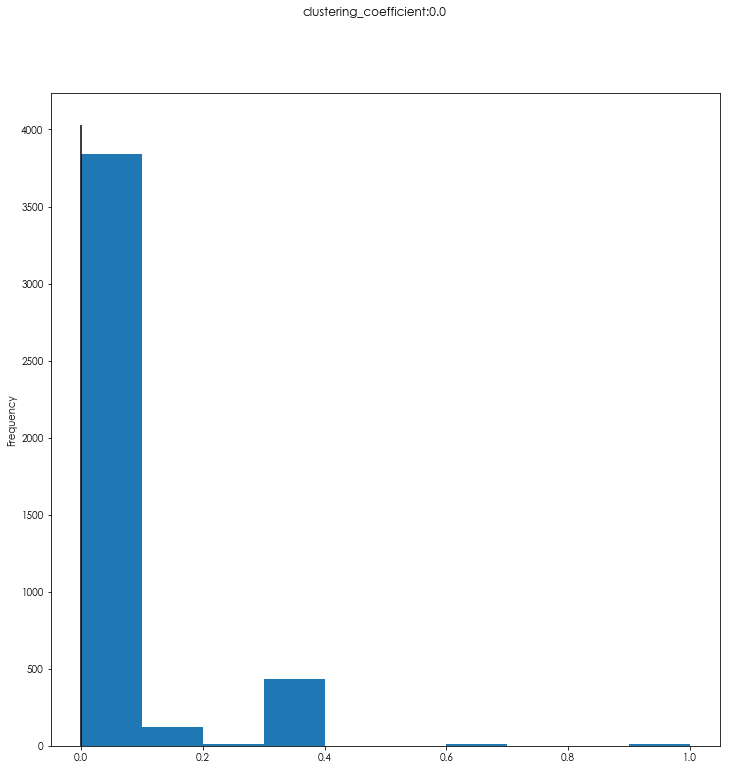

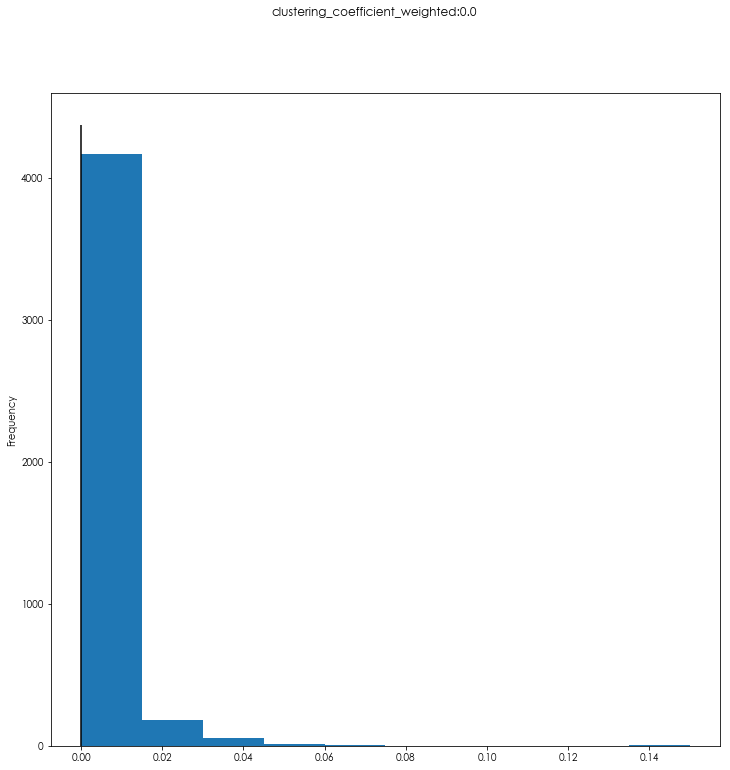

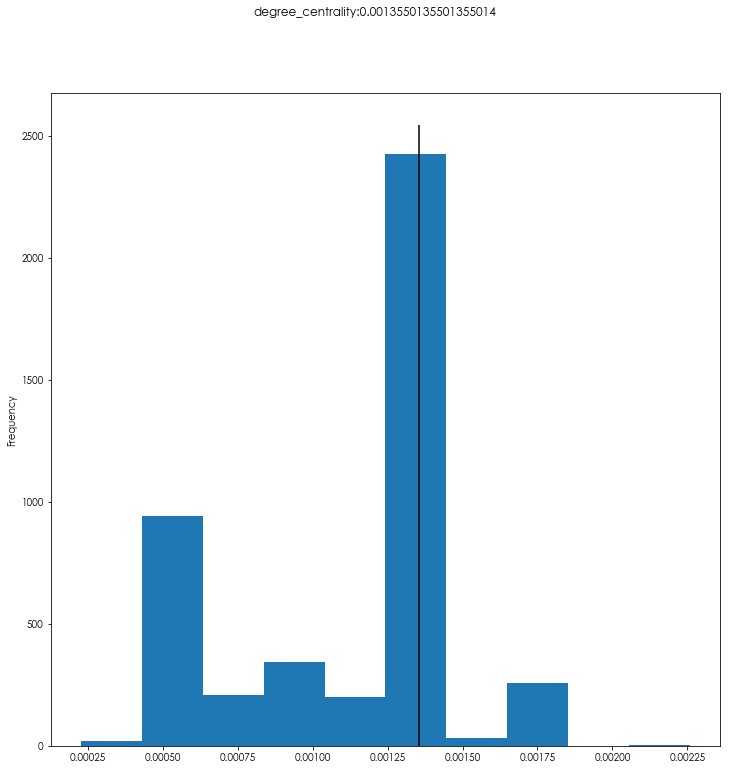

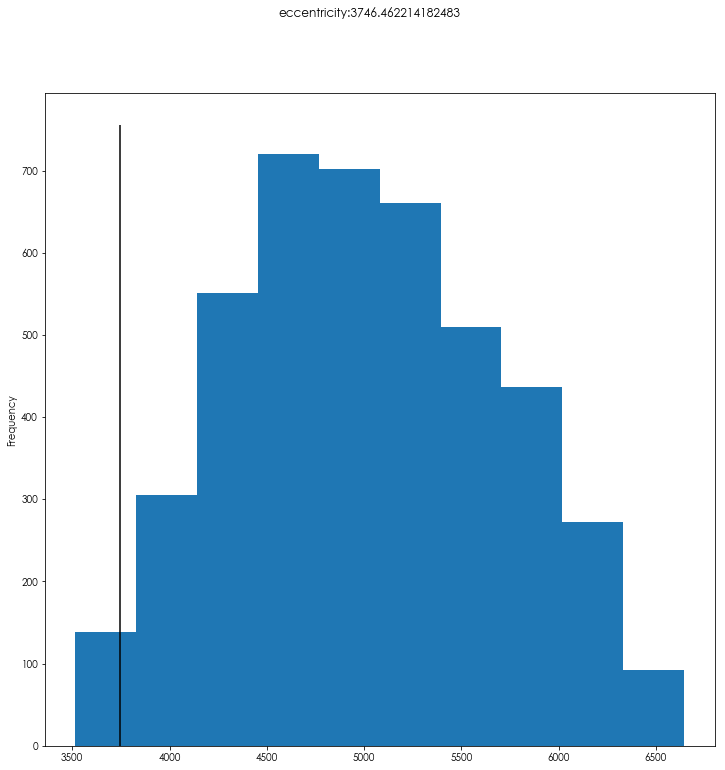

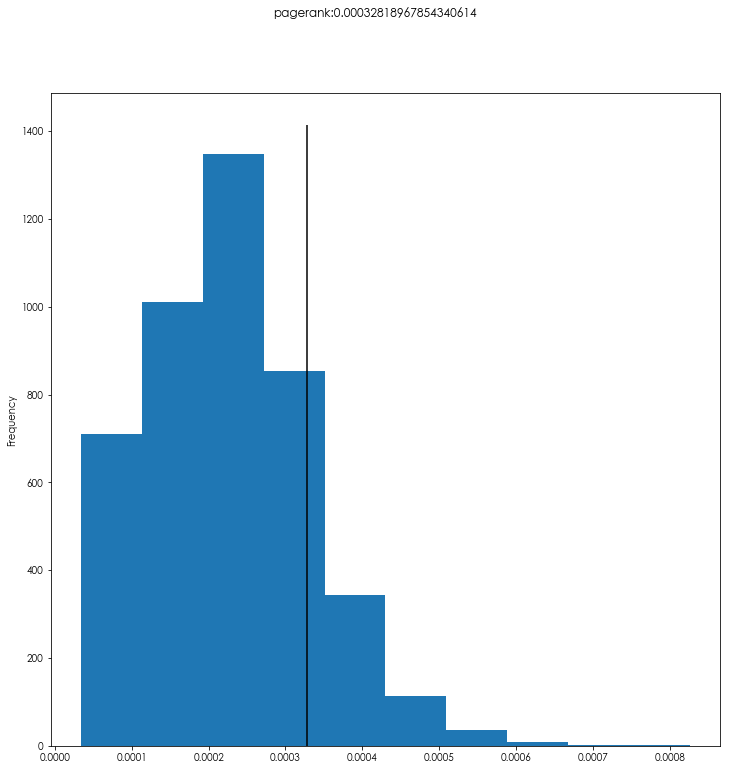

In [93]:
for measure, farsets in farset_stats.iteritems():
    f,ax = plt.subplots(figsize=(figsize,figsize))
    s=pd.Series(stats[measure])
    s.plot.hist(ax=ax)
    ylims = dict(zip(('ymin','ymax'),ax.get_ylim()))
    ax.vlines(farsets,**ylims)
    f.suptitle("{}:{}".format(measure,farsets))

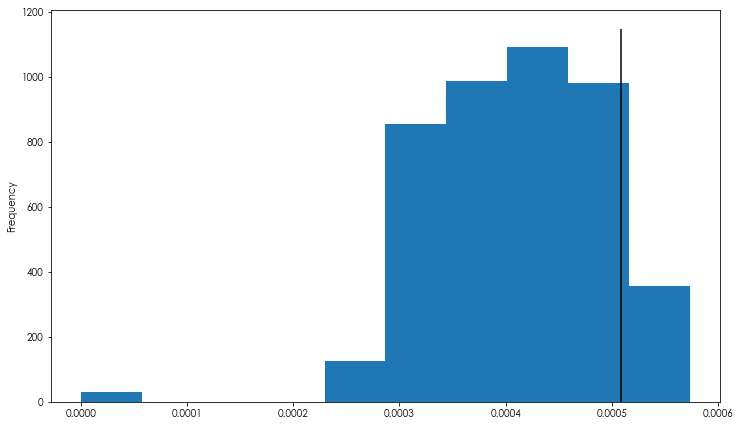

In [94]:
f,ax = plt.subplots(figsize = (figsize,0.6*figsize))
s=pd.Series(stats['closeness_centrality'])
s.plot.hist(ax=ax)
ylims = dict(zip(('ymin','ymax'),ax.get_ylim()))
ax.vlines(farset_stats['closeness_centrality'],**ylims)

In [95]:
s.rank(pct=True, ascending=False)[center_node]

0.10724768570783473

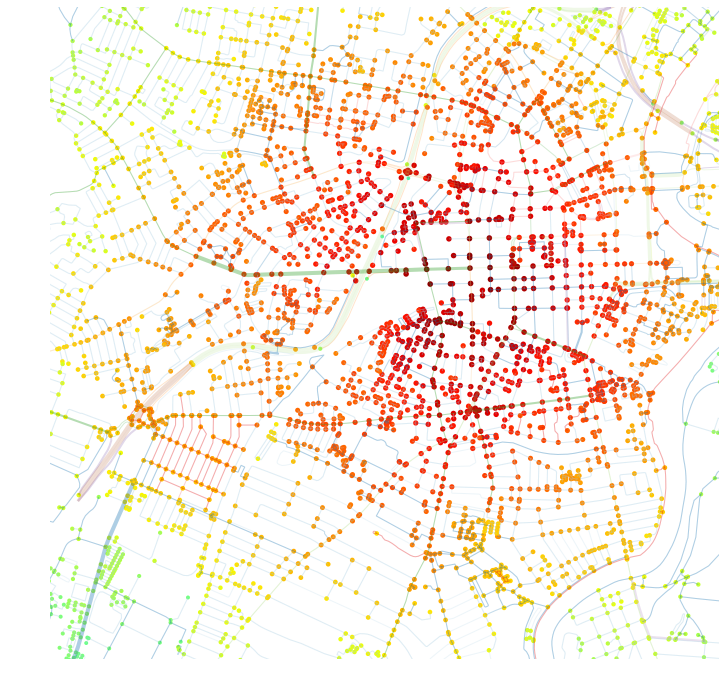

In [96]:
ndf['closeness_centrality'] = ndf['key'].apply(lambda k: extended_stats['closeness_centrality'][k] if k in extended_stats['closeness_centrality'] else np.nan)

cmap=plt.cm.get_cmap('jet')
from matplotlib import colors as colors
norm = colors.Normalize(vmin=ndf['closeness_centrality'].min(), vmax=ndf['closeness_centrality'].max())
_size = ndf['closeness_centrality'].apply(norm)*32
_colours = ndf['closeness_centrality'].apply(norm).apply(cmap).values
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=_size, node_color=_colours, 
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.2, bgcolor='w', 
                        show=True)

In [97]:
farset_paths = ox.nx.single_source_dijkstra_path_length(G, center_node, weight='length')


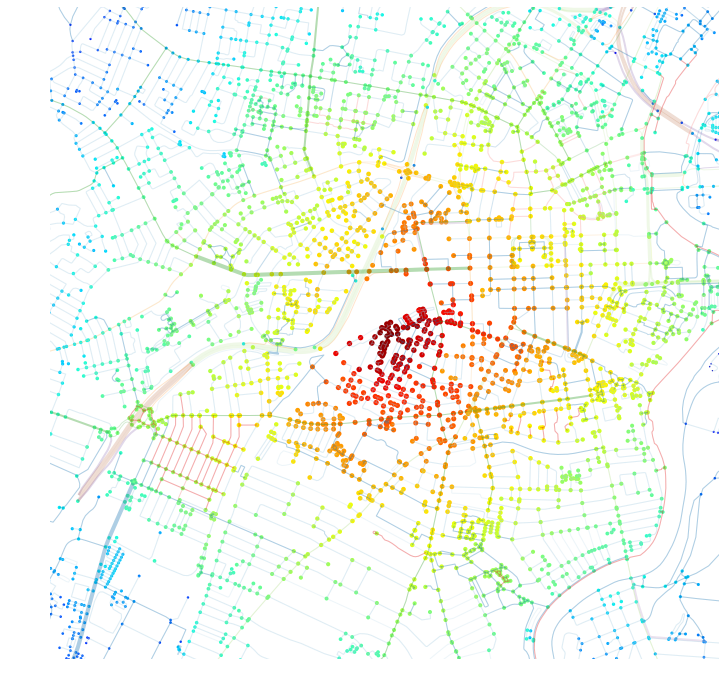

In [98]:
ndf['fsl_distance'] = ndf['key'].apply(lambda k: farset_paths[k] if k in farset_paths else None)
ndf['fsl_distance_invert'] = -ndf['fsl_distance']
norm = colors.Normalize(vmin=ndf['fsl_distance_invert'].min(), vmax=ndf['fsl_distance_invert'].max())
distance_size = ndf['fsl_distance_invert'].apply(norm)*32
distance_colours = ndf['fsl_distance_invert'].apply(norm).apply(cmap).values
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=distance_size, node_color=distance_colours, 
                        edge_linewidth=df['display_width'].values, file_format='png', edge_color=highway_colours, edge_alpha=0.2, bgcolor='w', 
                    )


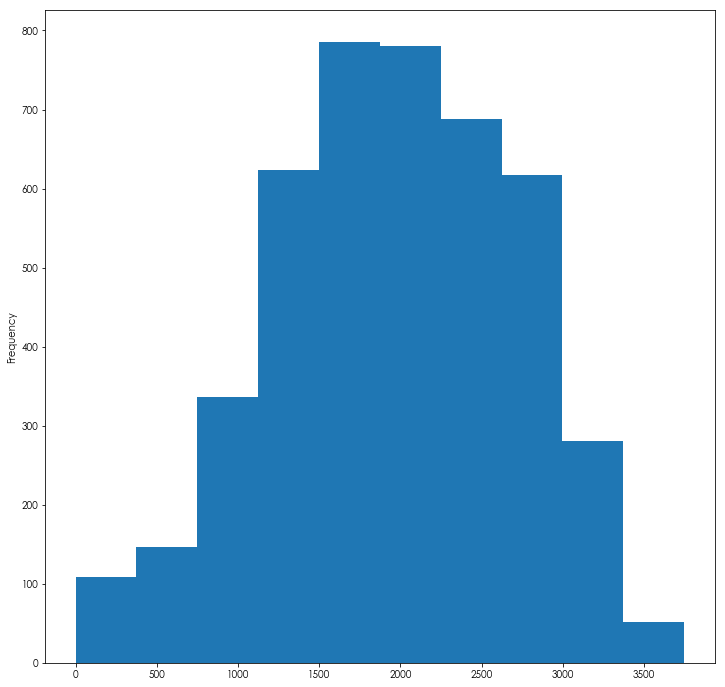

In [99]:
ndf['fsl_distance'].plot.hist(figsize=(figsize,figsize))

In [100]:
# add an edge attribute for time in minutes required to traverse each edge
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 5 #walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='jet', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = ox.nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]

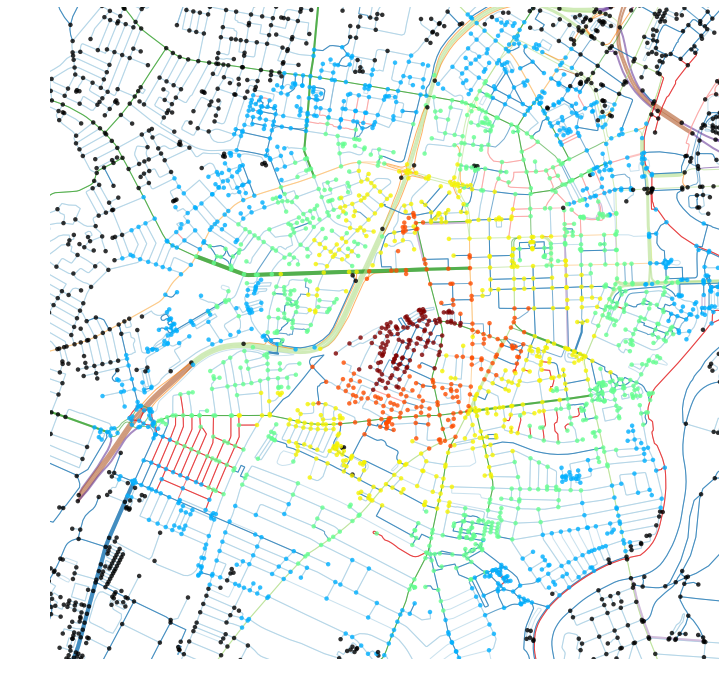

In [101]:
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, node_alpha=0.8, node_zorder=2,
                        bbox=bbox_proj, fig_height=figsize, margin=0, edge_linewidth=df['display_width'].values, 
                        file_format='png', edge_alpha=0.6, bgcolor='w',
                        edge_color=highway_colours)

In [102]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = ox.nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
    

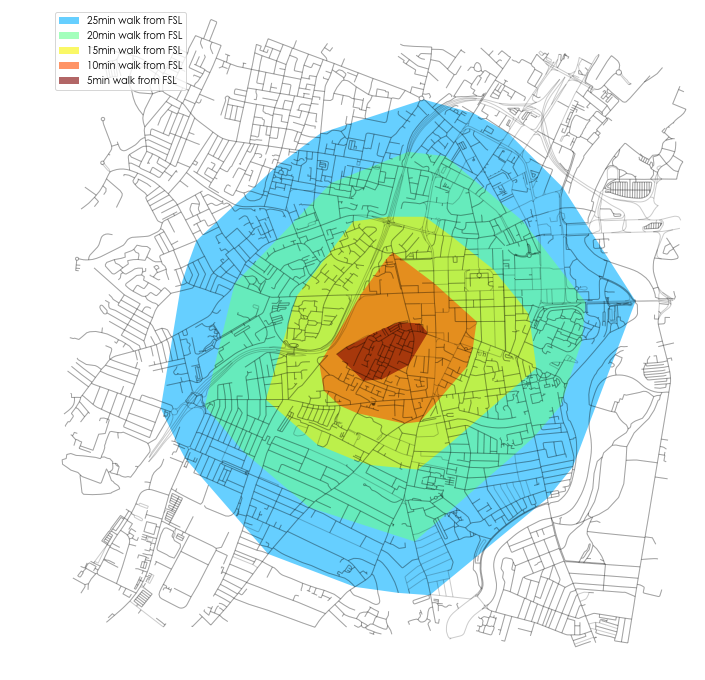

In [109]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=figsize, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
handles = []
labels=[]
for polygon, fc, trip_time in zip(isochrone_polys, iso_colors, reversed(trip_times)):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1, label="{}min walk from FSL".format(trip_time))
    ax.add_patch(patch)
    handles.append(patch)
plt.legend(handles=handles)
plt.show()

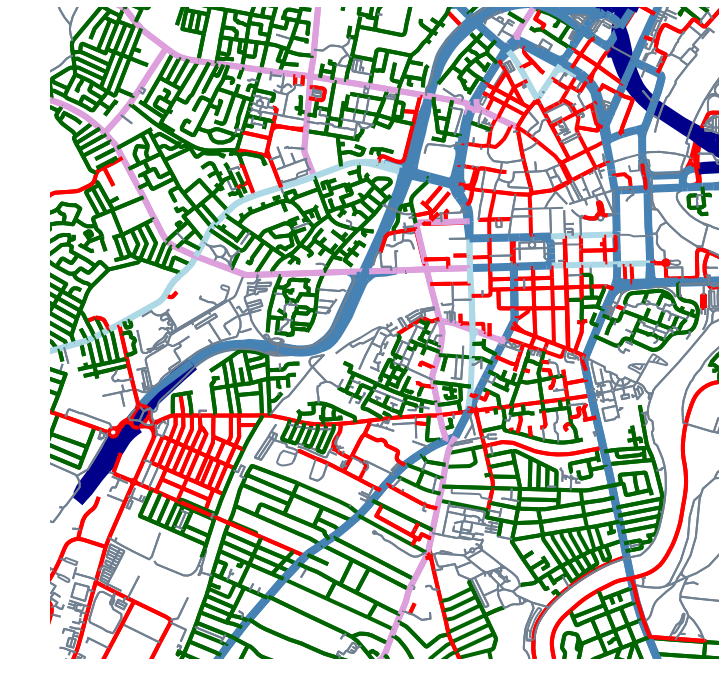

In [104]:
def highway_map(h_string):

    if h_string in ['footway', 'steps', 'pedestrian', 'service', 'path', 'track']:
        width = 1
        colour = 'slategrey'
    elif h_string in ['residential','living street']:
        width = 2
        colour = 'darkgreen'
    elif h_string in ['motorway','motorway_link']:
        width = 6
        colour = 'darkblue'
    elif h_string in ['trunk','trunk_link']:
        width = 4
        colour = 'steelblue'
    elif h_string in ['primary','primary_link']:
        width = 3
        colour = 'lightblue'
    elif h_string in ['secondary','secondary_link']:
        width = 3
        colour = 'plum'
    else:
        #print("No Match for {}".format(h_string))
        width=-1
        colour=None
        
    return width, colour

# ascribe street widths in pixels according to edge type
ew = []
ec = []
highways = []

for u, v, key, data in G.edges(keys=True, data=True):
    colour = None
    width = 0
    if isinstance(data['highway'], list):
        for h_string in data['highway']:
            _w,_c = highway_map(h_string)
            if _w > width:
                width,colour = _w, _c
    else:
        width, colour = highway_map(data['highway'])
    if width == -1:
        width = 2
        colour = 'r'
    if colour is None:
        colour = '#47494c'
    highways.append(data['highway'])
    ew.append(width*2)
    ec.append(colour)
    
# plot the graph and save it to disk
fig, ax = ox.plot_graph(G, bbox=bbox_proj, fig_height=figsize, margin=0, node_size=0, 
                        edge_linewidth=ew, file_format='png', edge_color=ec, bgcolor='w', 
                        show=True)

In [ ]:
raise ValueError("Stop Doing That")
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)


def highway_map(h_string):

    if h_string in ['footway', 'steps', 'pedestrian', 'service', 'footway', 'path', 'track']:
        width = 1
        colour = 'slategrey'
    elif h_string in ['residential']:
        width = 2
        colour = 'darkgreen'
    elif h_string in ['motorway','motorway_link']:
        width = 6
        colour = 'darkblue'
    elif h_string in ['trunk','trunk_link']:
        width = 4
        colour = 'steelblue'
    elif h_string in ['primary','primary_link']:
        width = 3
        colour = 'lightblue'
    else:
        width=-1
        colour=None
        
    return width, colour

dist = 805 #one half mile converted to meters
dist*=4

# create a list of place names, center lat-long points, and network types
places = [#['sf', (37.793897, -122.402189), 'drive_service'],
          #['portland', (45.517309, -122.682138), 'drive_service'],
          #['irvine', (33.694981, -117.841375), 'drive_service'],
          #['rome', (41.901336, 12.471831), 'all'],
          ['belfast', (54.5973, -5.9301), 'all'],
          #['farset', (54.592696, -5.940655), 'all']
         ]
highways = []
for name, point, nt in places:
    print(name, point)
    
    # get the network within 1/2 mile north, south, east, and west of the point, then project to UTM
    _G = ox.graph_from_point(point, distance=dist, distance_type='bbox', network_type=nt, truncate_by_edge=True)
    _G = ox.project_graph(G)
    
    # ascribe street widths in pixels according to edge type
    ew = []
    ec = []
    for u, v, key, data in _G.edges(keys=True, data=True):
        colour = None
        width = 0
        if isinstance(data['highway'], list):
            for h_string in data['highway']:
                _w,_c = highway_map(h_string)
                if _w > width:
                    width,colour = _w, _c

        width, colour = highway_map(data['highway'])
        if width == -1:
            width = 2
            colour = 'r'
        highways.append(data['highway'])
        ew.append(width*2)
        ec.append('w')
    
    # create the plot's bounding box in meters to limit the plot to the square mile bounding box requested
    # this is only necessary when truncate_by_edge=True to prevent display of nodes/edges that extend beyond bounding box
    _bbox_proj = ox.bbox_from_point(point, dist, project_utm=True)
    
    # plot the graph and save it to disk
    fig, ax = ox.plot_graph(_G, bbox=_bbox_proj, fig_height=figsize, margin=0, node_size=0, 
                            edge_linewidth=ew, file_format='png', edge_color=ec, bgcolor='#47494c', 
                            show=True, save=True, filename='gs_{}'.format(name))
